In [1]:
import festim as F
import fenics as f
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
# from festim import Export

Creating 2D mesh with FEniCS and marking its subdomains

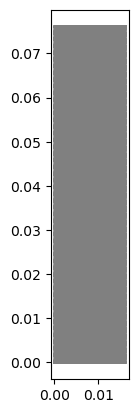

In [2]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = ny = 50
# mesh_fenics = UnitSquareMesh(nx, ny)

mesh_fenics = RectangleMesh(Point(0.0, 0.0), Point(0.0162, 0.0761), nx, ny)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0, tol)', tol=1e-14)
right_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0.0162, tol)', tol=1e-14)
bottom_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0, tol)', tol=1e-14)
top_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0.0761, tol)', tol=1e-14)

surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

# Surface ids
left_id = 1
top_id = 2
right_id = 3
bottom_id = 4
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_id)
bottom_surface.mark(surface_markers, bottom_id)

plot(mesh_fenics)

Functions defining flibe properties:

In [3]:
def density_flibe(T):
    return 2413 - 0.488 * T  # kg/m3


def viscosity_flibe(T):
    e = 2.718281828459045
    return 1.16e-04 * e ** (3755 / (T + DOLFIN_EPS))  # Pa.s


def beta_flibe(T):
    return 1.8319e-04 + 5.55e-08 * T  # K-1


def plot_properties():
    T = np.linspace(400, 1200, 1000)

    mu = viscosity_flibe(T)
    rho = density_flibe(T)
    beta = beta_flibe(T)

    plt.figure()
    mu *= 1e03
    plt.plot(T, mu, label="viscosity")
    plt.ylim(0, 30)
    plt.legend()

    plt.figure()
    plt.plot(T, rho, label="density")
    plt.ylim(1800, 2150)
    plt.legend()

    plt.figure()
    beta *= 1e04
    plt.plot(T, beta, label="Thermal expansion")
    plt.ylim(1.6, 2.8)
    plt.legend()

    plt.show()


CFD simulation function:

In [4]:

def velocity_field(T_cold, T_hot, my_mesh):
    """Computes the velocity field for a given mesh and temperature difference

    Args:
        T_cold (float): the cold temperature (right) in K
        T_hot (float): the hot temperature (left) in K
        my_mesh (fenics.Mesh): the mesh

    Returns:
        fenics.Function, fenics.Function, fenics.Function: veocity field (m/s), pressure (Pa), temperature (K)
    """
    T_bulk = ((T_hot - T_cold) / 2) + T_cold

    V_ele = VectorElement("CG", my_mesh.ufl_cell(), 2)
    Q_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    T_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    W = FunctionSpace(my_mesh, MixedElement([V_ele, Q_ele, T_ele]))

    upT = Function(W)
    upT_old = Function(W)
    u, p, T = split(upT)
    v, q, S = TestFunctions(W)

    for factor in [1e-03, 1e-02, 1e-01, 1]:
        print("Running for factor={:.1e}".format(factor))

        g = Constant((0, -9.81))  # gravity acceleration in m/s2
        mu = viscosity_flibe(T_bulk)  # dynamic viscosity in kg/m/s
        rho = density_flibe(T_bulk)  # density in kg/m3
        rho_0 = density_flibe(T_cold)  # density at T_cold
        cp = 2386  # heat capacity in J/(kg.K)
        thermal_cond = 1.1  # thermal conductivity in W/(m.K)
        beta = beta_flibe(T_bulk) * factor

        # CFD momentum
        F = (
            rho_0 * inner(dot(grad(u), u), v) * dx
            - inner(p, div(v)) * dx
            + mu * inner(grad(u), grad(v)) * dx
            + inner(rho_0 * beta * (T - T_bulk) * g, v) * dx
        )

        # CFD continuity
        F -= inner(q, div(u)) * dx

        # Heat transfer
        F += rho * cp * inner(dot(grad(T), u), S) * dx
        F += inner(thermal_cond * grad(T), grad(S)) * dx

        bcs = [
            DirichletBC(W.sub(0), Constant((0, 0)), "on_boundary"),
            DirichletBC(W.sub(2), T_hot, "on_boundary && x[0] == 0"),
            DirichletBC(W.sub(2), T_cold, "on_boundary && x[0] == 0.0162"),  # TODO make this more generic
        ]

        solve(
            F == 0,
            upT,
            bcs=bcs,
            solver_parameters={
                "newton_solver": {
                    "linear_solver": "mumps",
                    "absolute_tolerance": 1e-09,
                    "relative_tolerance": 1e-09,
                    "maximum_iterations": 25,
                }
            },
        )

        upT_old.assign(upT)

    u, p, T = upT.split()

    return u, p, T


Diffusion Simulation:

In [5]:
def my_simulation(temperature_field, mesh_fenics, velocity):
    """
    Takes in a list of temperatures and a set mesh and returns a list of diffusion coefficients that correspond to each temperature

    Args:
        temperature_field (fenics.Function): the temperature field in K
        mesh_fenics (fenics.Mesh): the mesh (should be the same as the one used to compute the temperature field)
        velocity (fenics.Function): the velocity field in m/s

    Returns:
        float: the mass transport coefficient in m/s
    """
    # setting up current simulation
    model_2d = F.Simulation()

    # D, E_d source: "nakamura_hydrogen_2015"
    # Thermal cond source: https://dspace.mit.edu/bitstream/handle/1721.1/123988/Romatoski_SaltPropertyReview02.pdf?sequence=1&isAllowed=y#:~:text=From%20the%20data%20collected%2C%20the,an%20uncertainty%20of%20%C2%B110%25.
    flibe_mat = F.Material(
        id=1,
        D_0=1.508521565198744e-08,
        E_D=0.23690444592353738,
        thermal_cond=1.1  #  <--- not needed here
        )
    model_2d.materials = F.Materials([flibe_mat])

    # creating mesh with festim
    model_2d.mesh = F.Mesh(
        mesh=mesh_fenics,  # TODO we should be able to get the mesh from the temperature field
        volume_markers=volume_markers,
        surface_markers=surface_markers
    )

    # setting up steady state heat transfer problem

    # model_2d.T = F.TemperatureFromXDMF(temperature_file, label="temperature")
    model_2d.T = F.Temperature(value=973)  # dummy temperature, will be overwritten later


    # setting up T source
    model_2d.sources = [
        F.Source(
            value=1.84*10**5/(0.0761*0.0162), 
            volume=1, 
            field=0
            )
        ]

    
    # setting up transport boundary conditions
    tritium_transport_bcs = [
        F.DirichletBC(
            surfaces=[top_id, bottom_id, right_id], 
            value=0, 
            field=0
            )
    ]

    model_2d.boundary_conditions = tritium_transport_bcs

    
    # simulation parameters and running model
    model_2d.settings = F.Settings(
        transient=False,
        absolute_tolerance=1e-09,
        relative_tolerance=1e-09,
    )

    # setting up exports
    export_folder = "BABY_2D_results"

    derived_quantities = F.DerivedQuantities(filename=export_folder + "/simulation.csv")

    derived_quantities.derived_quantities = [
        F.SurfaceFlux(field="solute", surface=left_id),
        F.SurfaceFlux(field="solute", surface=right_id),
        F.SurfaceFlux(field="solute", surface=top_id),
        F.SurfaceFlux(field="solute", surface=bottom_id),
        F.AverageVolume(field="solute", volume=1)
        ]

    model_2d.exports = F.Exports([
        F.XDMFExport("solute", folder=export_folder),
        F.XDMFExport("retention", folder=export_folder),
        F.XDMFExport("T", folder=export_folder),
        derived_quantities
        ])
    # adding advection
    model_2d.initialise() # reinitialisation is needed

    model_2d.T.T = temperature_field
    model_2d.T.T_n = temperature_field  # don't know if this is needed

    hydrogen_concentration = model_2d.h_transport_problem.mobile.solution
    test_function_solute = model_2d.h_transport_problem.mobile.test_function

    advection_term = inner(dot(grad(hydrogen_concentration), velocity), test_function_solute) * model_2d.mesh.dx

    model_2d.h_transport_problem.F += advection_term

    model_2d.run()

    plt.figure()
    plt.title("Hydrogen concentration")
    CS = plot(hydrogen_concentration)
    plot(velocity, scale=1e-3, color="black", alpha=0.5)
    plt.colorbar(CS, label="H/m3")
    plt.show()
    

    # reading results
    my_data = np.genfromtxt(export_folder + "/simulation.csv", names=True, delimiter=",")

    flux_1 = my_data["Flux_surface_1_solute"]
    flux_2 = my_data["Flux_surface_2_solute"]
    flux_3 = my_data["Flux_surface_3_solute"]
    flux_4 = my_data["Flux_surface_4_solute"]

    # calculating diffusion coefficient
    total_flux = abs(flux_1 + flux_2 + flux_3 + flux_4)

    average_conc = my_data["Average_solute_volume_1"]

    A = 0.0761*0.0162  # m2
    k = total_flux/(A*average_conc)

    print(f"Total flux: {total_flux} H/s/m")
    print(f"Average concentration: {average_conc} H/m3")
    print(f"k: {k} /s  (double check the units)")

    return k

----------  Running for dT=0 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


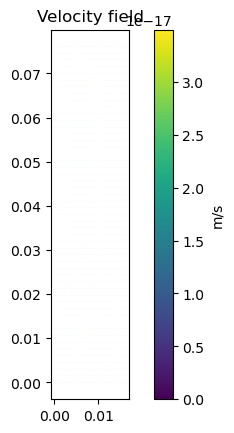

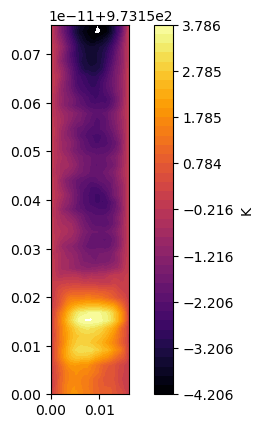

/home/remidm/FESTIM/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


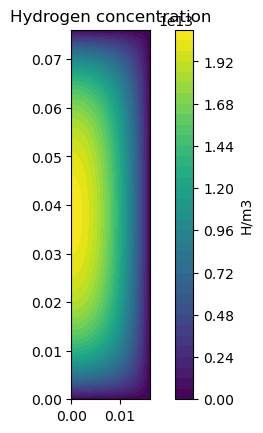

Total flux: 177258.48358270584 H/s/m
Average concentration: 10674840334994.125 H/m3
k: 1.3469329289779898e-05 /s  (double check the units)
----------  Running for dT=0.1 K  ----------
Running for factor=1.0e-03
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running for factor=1.0e-02
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running for factor=1.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running for factor=1.0e+00
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


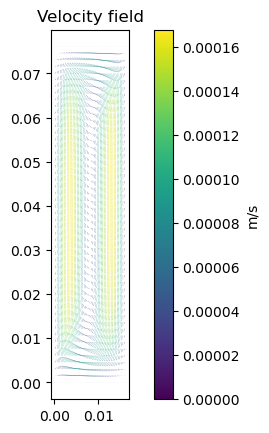

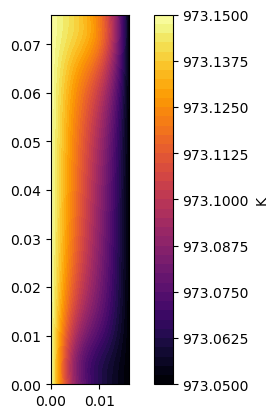

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


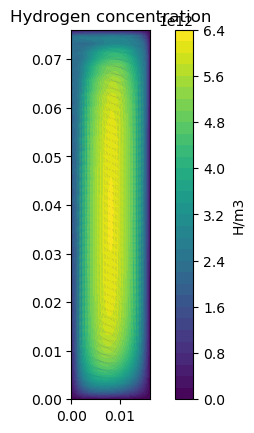

Total flux: 169427.74934728304 H/s/m
Average concentration: 3910702376647.9023 H/m3
k: 3.514229379232773e-05 /s  (double check the units)
----------  Running for dT=0.2 K  ----------
Running for factor=1.0e-03
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running for factor=1.0e-02
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running for factor=1.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Running for factor=1.0e+00
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


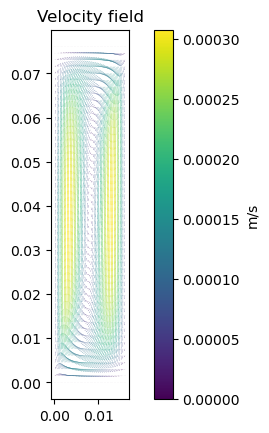

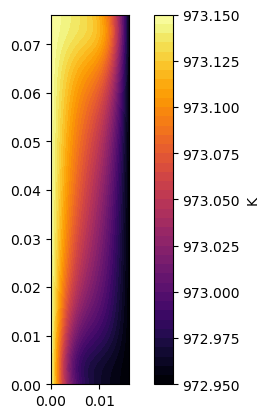

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


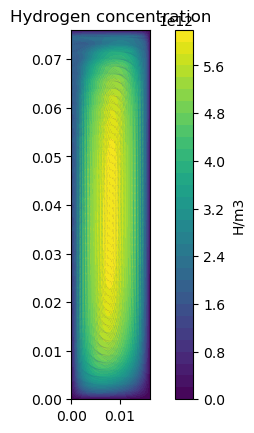

Total flux: 168774.50492541742 H/s/m
Average concentration: 3757310608250.48 H/m3
k: 3.643594792792958e-05 /s  (double check the units)
----------  Running for dT=0.5 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


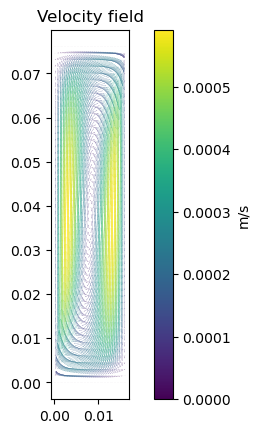

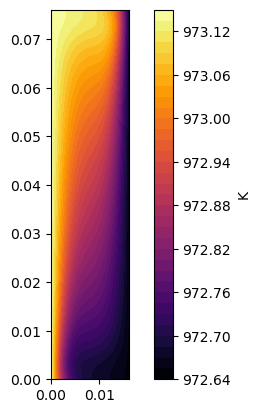

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


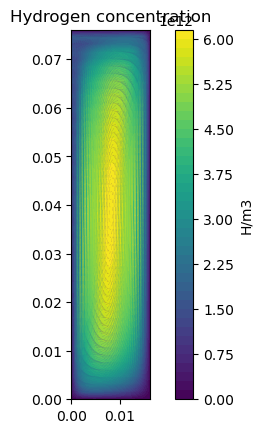

Total flux: 167701.16070334736 H/s/m
Average concentration: 3599241256717.8096 H/m3
k: 3.779422453087904e-05 /s  (double check the units)
----------  Running for dT=1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


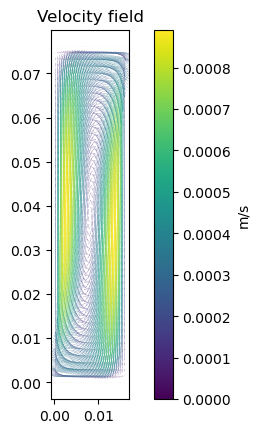

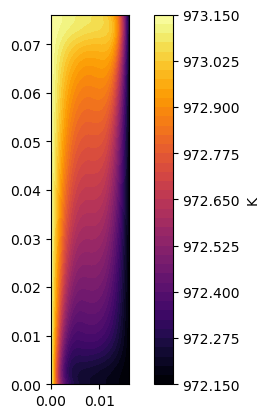

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


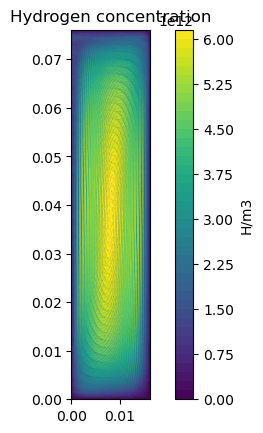

Total flux: 166053.32791516467 H/s/m
Average concentration: 3513968219926.8687 H/m3
k: 3.8330994134873144e-05 /s  (double check the units)
----------  Running for dT=7 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


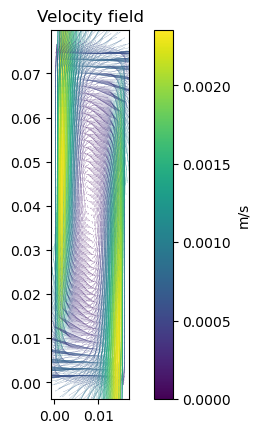

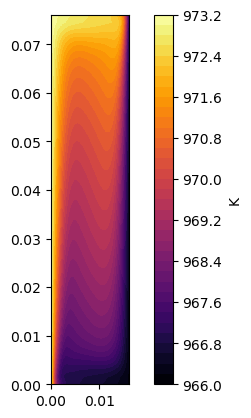

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.20 s


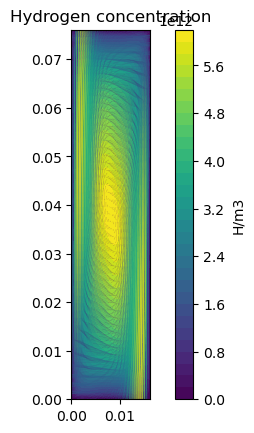

Total flux: 164978.73663343705 H/s/m
Average concentration: 3299958329549.454 H/m3
k: 4.0552706682774e-05 /s  (double check the units)
----------  Running for dT=10 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


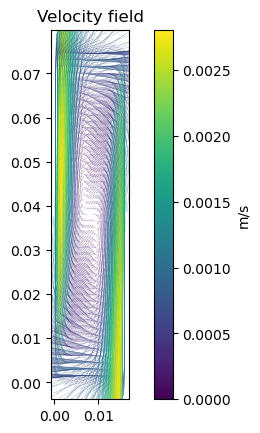

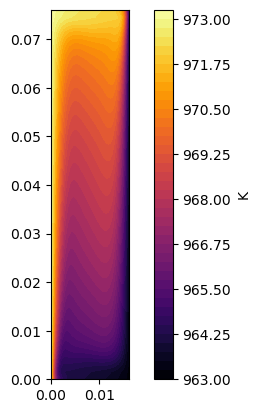

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


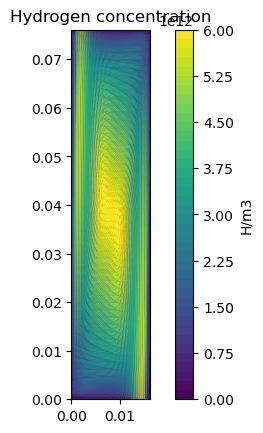

Total flux: 167887.54756442006 H/s/m
Average concentration: 3215739172893.2427 H/m3
k: 4.2348496654743815e-05 /s  (double check the units)


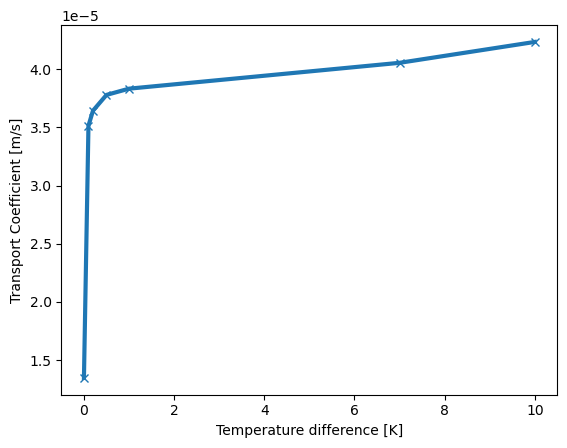

In [9]:
if __name__ == "__main__":
    T_hot = 700 + 273.15

    dt_array = [0, 0.1, 0.2, 0.5, 1, 7, 10]
    k_array = []
    for dT in dt_array:
        print(f"----------  Running for dT={dT} K  ----------")
        foldername = f"Results/dt={dT}/"
        T_cold = T_hot - dT
        u, p, T = velocity_field(T_cold=T_cold, T_hot=T_hot, my_mesh=mesh_fenics)

        XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(T, "temperature", 1, XDMFFile.Encoding.HDF5)
        XDMFFile(foldername + "velocity_field.xdmf").write(u)

        plt.figure()
        plt.title("Velocity field")
        CS = plot(u, scale=1e-3)
        plt.colorbar(CS, label="m/s")
        plt.show()

        plt.figure()
        TS = plot(T, cmap="inferno")
        plt.colorbar(TS, label="K")
        plt.show()

        k = my_simulation(T, mesh_fenics, u)
        k_array.append(k)

    plt.plot(dt_array, k_array, '-x', linewidth=3)
    plt.xlabel("Temperature difference [K]")
    plt.ylabel("Transport Coefficient [m/s]")